# Bike Price Prediction

## 1. Problem Formulation


The goal of the project is to create a  deep-learning model to predict the offer-price in Euros of a bicycle given an image of the same bycicle.
The idea for this problem is inspired by the [CS229 2018 Stanford course](https://www.example.com), where one of the instructors proposes a similar semester project.
<br>
The web is scraped for images of bicycles and their corresponding prices.

2. Initially, the data is to be explored to show potential areas of improvement. Some problems for preprocessing might include:
- Filtering out non-bicycle images
- bicycles with non-monotonous background and bicycles not facing sideways
- data bias (source, color, resolution, orientation)
- incorrect pricing

3. A baseline model using the Residual Neural Network architecture is built
- only basic preprocessing steps are applied to the training data
- the loss function and metrics are defined
- the model is trained and progress visualized
- the trained model's layer activations and the prediction heatmap is visualized

4. The baseline model is improved
- data augmentation is applied
- hyperparamter tuning (using bayesian optimization) is applied
- the activations and the heatmap is visualized

## 2. Preliminaries

#### Neural Networks

#### Convolutional Neural Networks
Convolutional Neural Networks (CNNS) were first proposed by  LeCun et al. in 1998.
The domain they are mostly used in is computer vision, extracting knowledge from images.

CNNS implement an operation called the convolution, where a filter "slides" or convolves across the input to compute a feature map. This operation is implemented in two dimensions as shown in equation $(1)$, where $Y[i,j]$ is the feature map at position $(i,j)$, $X$ the input and $H$ the filter with dimensions $K \times K$.

$$
\begin{equation}
Y[i, j] = \sum_{m=0}^{K-1} \sum_{n=0}^{K-1} X[i+m, j+n] \cdot H[m, n]  \quad \text(1)
\end{equation}
$$

The dimensions of $Y$ are determined by the formula $(2)$ for each of the $n$ dimensions. The $Stride$ determines which "step-size" the convolution operation uses. $Padding$ may be concatenated around the input, for example zero-padding. The formula can be rewritten to find the ideal stride, padding or kernel size, to keep or reduce the feature dimensions from $X$ to $Y$ using the convolution operation.    



$$
\begin{equation}
\text{Output Size} = \left(\frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}}\right) + 1 \quad \text(2)
\end{equation}
$$

Another operation in the CNN is the pooling operation. Essentially, it is a convolution operation, were the mean or the maximum in the filter window is extracted.


Making use of the convolution operations, data with low signal-to-noise ratio, like images, can be reduced to essential features. The sliding window approach enabels parameter-sharing for each of the inputs and thereby also reduce computational cost. This is effective because in images local features often can also be found globally. CNNs can be used for arbitrarily n-dimensional data, examples include one-dimensional signal processing or cancer detection from a three-dimensional scan, where the filter is n-dimensional respectively.

Filters are initialized randomly and improved using backpropagation.

CNNs can use multiple per layer...


@article{LeCun1998GradientbasedLA,
  title={Gradient-based learning applied to document recognition},
  author={Yann LeCun and L{\'e}on Bottou and Yoshua Bengio and Patrick Haffner},
  journal={Proc. IEEE},
  year={1998},
  volume={86},
  pages={2278-2324}
}

Alakwaa, Wafaa, Mohammad Nassef, and Amr Badr. "Lung cancer detection and classification with 3D convolutional neural network (3D-CNN)." International Journal of Advanced Computer Science and Applications 8.8 (2017).



In [1]:
## He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

In [1]:
# Imports and Global Variables
import os
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from google.colab import drive
drive.mount('/content/drive')
DRIVE_FOLDER = Path('/content/drive/MyDrive/DataExplorationProject/')
SEED = 4 # random seed
np.random.seed(SEED)

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity



Mounted at /content/drive


## 3. Data exploration, overview, cleaning

### 3.1 Webscraping and cleaning considerations
50000 images from the web are accumulated.

#### Scraping
1. High quality images come from the websites "fahrrad.de" (1500 images) and "www.fahrrad-xxl.de" (5500 images).
2. The remaining ~7000 images are scraped from the "shopping" tab of "www.google.com". After trial and error, following methods are recognized to work well using the keywords "bicycle","citybike", "ebike", "mountainbike", "racingbike", "childrens bike", "trekkingbike", "holland bicycle", "bmx" and their german equivalents. These keywords cover the common types.

   2.1. First method: Scraping is executed using breathfirst search, starting with the above-mentioned initial keywords. The links of the (n+1)-depth are found  by the "further recommendations" in each (n)-depth search. Already downloaded images are tracked in a csv file. It is found that a depth of  n=2 is sufficient, the amount of new images in depth n>2 is sparse.
   
   2.2. Second method: Above-mentioned keywords are combined with the words of bicycle colors (['blue','brown','yellow','orange','turkis','purple','white', 'grey', 'green','red','silver']) and also price ranges (200 till 1500 in "50" steps, 1500 till 3000 in "500" steps, 3000 till 6000 in "3000" steps) to scrape further images.  
3. In both cases, also the subsequent pages of each search result are crawled. The technologies used for web-crawling are [Scrapy](https://scrapy.org/) (for 1.), a efficient scraping library, and  [microsoft-playwright](https://playwright.dev/) (for 2.), which is similar to [Selenium](https://www.selenium.dev/) a browser-based test-automation tool, but may be utilized for scraping. Playwright allows for better page accessibility than Scrapy.

#### Considerations for subsequent exploration and cleaning
1. Especially the data scraped from google.com includes images of other objects or multiple bicycles. The inclusion of images of bicycles with non-monotonous or with non-sideview depiction may increase the difficulty for an algorithm to depict features of a bike, and therefore 50000 images may not be sufficient.
1. The scraped bicycle images and their prices are likely to include regional bias (Germany), as well as incorrect, only regional pricing. Also, the prices are dependent on the date extracted (June 2023). As mentioned in the problem formulation, assigned prices are solely "offer"-prices and may not reflect the prices for which they are sold.

Option: Precompute image Embeddings of the frozen layers of the CNN. This saves computational cost and time

--- exploratory data analysis ideas: compute "average image", see eigenfaces or fisher faces https://en.wikipedia.org/wiki/Eigenface or simply compute mean image, compute this per price range, plot image dimensions on x, y axis. Plot these or also plot colors per price range to see if there are any color biases.

use weights and biases to track data

### 3.2 Data Exploration and cleaning

In [ ]:
if not 'unzipped' in globals():
  !unzip /content/drive/MyDrive/DataExplorationProject/bicycles_xxl.zip
  !unzip /content/drive/MyDrive/DataExplorationProject/bicycles_de.zip
  !unzip /content/drive/MyDrive/DataExplorationProject/bicycles_goog.zip
  unzipped =True

Archive:  /content/drive/MyDrive/DataExplorationProject/bicycles_xxl.zip
   creating: content/bicycles_xxl/
  inflating: content/bicycles_xxl/73096c95-4873-4703-934e-a39771bfa089_5999.jpg  
  inflating: content/bicycles_xxl/d2477bce-1119-4ff6-8219-1e5c2fa9cf67_2499.jpg  
  inflating: content/bicycles_xxl/a36f3745-2f09-4235-89a3-a8d10110c991_4799.jpg  
  inflating: content/bicycles_xxl/9c70a78a-80-4afb-bfc6-467142efa38e_5199.jpg  
  inflating: content/bicycles_xxl/b7c944ff-0da6-4f53-90d1-e89cef3a1629_1099.jpg  
  inflating: content/bicycles_xxl/73988692-70b1-4375-8420-f96790f5e7_1539.99.jpg  
  inflating: content/bicycles_xxl/d8aff6e0-bb86-4903-b2c6-ec57814e97c8_2849.jpg  
  inflating: content/bicycles_xxl/43e38c74-0b26-4d41-9cb0-f0ff472da2ce_4699.jpg  
  inflating: content/bicycles_xxl/34fddd86-4769-4d7a-b9af-d088b41f594f_649.jpg  
  inflating: content/bicycles_xxl/27dca815-85f6-476d-a9-019854a97fa4_5199.jpg  
  inflating: content/bicycles_xxl/c3da44c3-f782-413f-a49a-39f1faa84494_2349.

#### 2.2.1 Removing duplicate images
The webscraping process does not ensure that only unique images are loaded.
1. Compute image embeddings with a standard 50 resnet-blocks deep resnet which was pretrained on the ImageNet dataset. Only the base model without the prediction head is used. "model.summary()" below shows the architecture of the model. The output of the last average-pooling layer is used for the embeddings thus each image is represented by a 2048-dimensional vector.

2. filter images: label some "bad" examples by hand, and use their embeddings to localize similar images
3. verify visually

The question may arise, why the embeddings are useful for this task. The ResNet was pretrained on the ImageNet dataset. In detail, the dataset consists of images of 1000 different classes, and the model is trained to differentiate between those classes. As such, it has learned the differences between the images, which are annotated by humans. Therefore it also has learned some notion of "difference" between the objects, similar to the visual differences humans perceive. Because of the large number of classes to be distinguished, the model has to learn a generalization to perform well. Therefore the embeddings might allow a separation of the images by object type, even beyond the 1000 classes the model has learned to distinguish.

In [ ]:
# Load  pretrained ResNet50 model, was pretrained on 1000 class imagenet
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
model_clf_head = Model(inputs=base_model.get_layer('avg_pool').output, outputs=base_model.get_layer('predictions').output)

In [5]:
# we take last layers output, model is without classification head
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# 1. Compute embeddings


# preprocess imgs
def preprocess_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_data = image.img_to_array(img)
  img_data = np.expand_dims(img_data, axis=0)
  img_data = preprocess_input(img_data)
  return img_data

# compute embeddings
def compute_embeddings(folder_path, batch_size=64):
  dataset_name = folder_path.split('/')[-1]
  p = DRIVE_FOLDER/(dataset_name+'_resnet50embeddings.npz')

  if os.path.exists(p): # load embeddings instead of computing, if already recomputed
    print(f"load already precomputed embeddings in file {p}")
    return np.load(p)

  image_list = os.listdir(folder_path)
  num_images = len(image_list)
  num_batches = int(np.ceil(num_images / batch_size))

  image_embeddings = {}

  for i in tqdm(range(num_batches),total=num_batches):
    batch_images = []
    start = i * batch_size
    end = min((i + 1) * batch_size, num_images)

    for j in range(start, end):
      try:
        img_path = os.path.join(folder_path, image_list[j])
        img_data = preprocess_image(img_path)
      except BaseException as e:
        print(e, image_list[j])
      batch_images.append(img_data)

    batch_data = np.vstack(batch_images)
    batch_embeddings = model.predict(batch_data)

    for j in range(batch_embeddings.shape[0]):
      image_embeddings[os.path.join(folder_path, image_list[start + j])] = batch_embeddings[j]

  return image_embeddings

# Compute embeddings for images in all folders
embeddings_goog = compute_embeddings('/content/bicycles_goog')
embeddings_de = compute_embeddings('/content/bicycles_de')
embeddings_xxl = compute_embeddings('/content/bicycles_xxl')

In [4]:
embeddings = {}
for _dict, source in zip([embeddings_goog, embeddings_de, embeddings_xxl],['goog','de','xxl']):
  for key in _dict:
    embeddings[Path(key).name] = {'embedding':_dict[key], 'source':source}

In [8]:
# 2.0 get already handlabeled images
!unzip /content/drive/MyDrive/DataExplorationProject/'image_classes.zip'

Archive:  /content/drive/MyDrive/DataExplorationProject/image_classes.zip
   creating: content/image_classes/
   creating: content/image_classes/x_only_chassy/
  inflating: content/image_classes/x_only_chassy/4b6921ea-822a-3628-8c02-80b48598ed80_392.43.jpg  
  inflating: content/image_classes/x_only_chassy/9fa49abd-6580-3f5c-a8ff-aeb1bd744611_600.62.jpg  
  inflating: content/image_classes/x_only_chassy/4a89bc4d-bcd2-352b-b0ec-c293fd056307_569.00.jpg  
  inflating: content/image_classes/x_only_chassy/9d032ed3-8275-3b15-8559-ae9525920b3d_524.44.jpg  
  inflating: content/image_classes/x_only_chassy/0e999b9e-3fed-31ed-897e-887abae37249_640.00.jpg  
  inflating: content/image_classes/x_only_chassy/db157d46-181c-36ae-8e39-4ea4136f8e58_582.79.jpg  
  inflating: content/image_classes/x_only_chassy/0a04c31e-044e-3bf1-a948-1351cc42c0a2_923.40.jpg  
  inflating: content/image_classes/x_only_chassy/dbae9a1b-e702-31e9-87c7-3f5ac577313b_482.88.jpg  
  inflating: content/image_classes/x_only_chassy

In [9]:
!ls /content/content/image_classes

bike_not_fromside_or_only_part	    childrensbike  mountainbike  x_only_chassy
bike_with_nonmonotonous_background  citybike	   racing_bike	 xonlywheels
bmx				    ebike	   xnobike


In [10]:
from matplotlib.layout_engine import TightLayoutEngine
# code adapted from https://stackoverflow.com/a/72804014
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
imagename_to_path = {}
for folder in ['/content/content/bicycles_xxl/','/content/content/bicycles_de/','/content/content/bicycles_all/']:
   imagename_to_path.update({v:folder+v for v in os.listdir(folder)})

def plot_image_urls(img_urls_temp, col_count=10, img_text=None):
  img_urls = []
  for url in img_urls_temp:
    if Path(url).name in imagename_to_path.keys():
      img_urls.append(imagename_to_path[Path(url).name] )




  images = [
      mpimg.imread(url) for url in img_urls
  ]
  row_count = int(len(img_urls)/col_count) + 1

  fig = plt.figure(figsize=(8., 18.))
  grid = ImageGrid(fig, 111, nrows_ncols=(row_count, col_count), axes_pad=0.1)

  if img_text is None:
    img_text = ['' for _ in range(len(img_urls))]
  for ax, im, txt in zip(grid, images, img_text):
      ax.imshow(im)
      ax.set_title(txt, fontdict=None, loc='center', color = "k")

  plt.show()

In [11]:
Path('/content/content/image_classes/x_only_chassy/0e999b9e-3fed-31ed-897e-887abae37249_640.00.jpg').name in imagename_to_path.keys()

True

In [12]:
imagename_to_path['0e999b9e-3fed-31ed-897e-887abae37249_640.00.jpg']

'/content/content/bicycles_all/0e999b9e-3fed-31ed-897e-887abae37249_640.00.jpg'

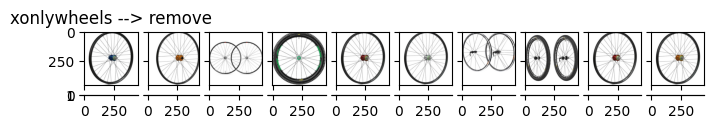

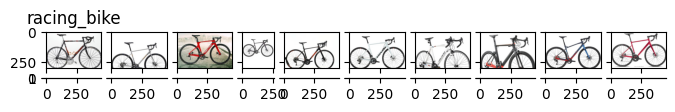

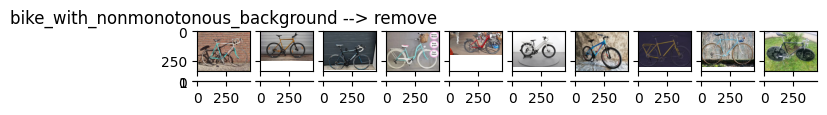

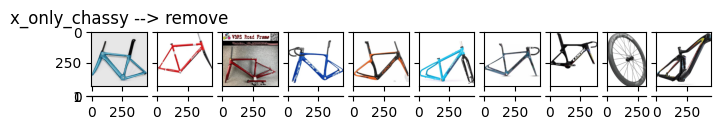

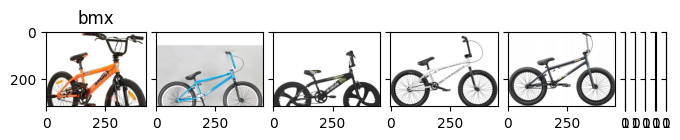

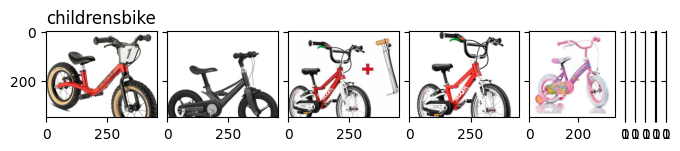

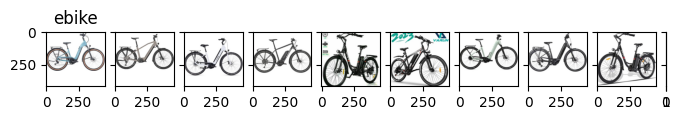

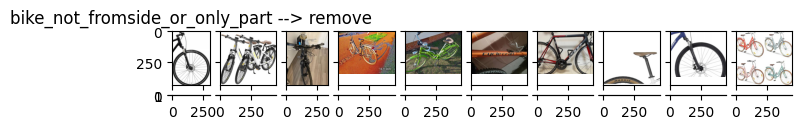

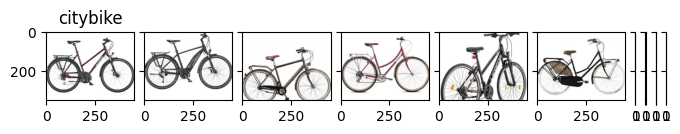

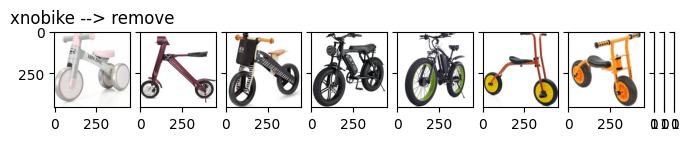

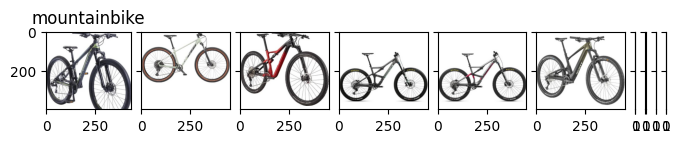

In [13]:
folder = Path('/content/content/image_classes')

potential_remove_categories = ['bike_not_fromside_or_only_part', 'bike_with_nonmonotonous_background','x_only_chassy', 'xonlywheels', 'xnobike']
image_classes = {category:{'remove':category in potential_remove_categories, 'images': [folder/category/img for img in os.listdir(folder/category) ]} for category in os.listdir(folder) }

for category, category_data in image_classes.items():
  take = 10
  images = category_data['images'][:take]

  titles = [category+' --> remove' if category_data['remove'] and i==0 else category if i==0 else '' for i in range(len(images))]

  plot_image_urls(images, img_text=titles, col_count = take)


In [14]:
# add embedding_center to classes
for c in image_classes:
  class_embeddings = []
  for img_path in image_classes[c]['images']:
    key = Path(img_path).name
    if key in embeddings:
      class_embeddings.append(embeddings[key]['embedding'])

  class_embeddings = np.array(class_embeddings)
  mean_embedding = np.mean(class_embeddings, axis = 0)
  image_classes[c]['embeddings'] = class_embeddings
  image_classes[c]['mean_embedding'] = mean_embedding
  print(f'{len(class_embeddings)} images of class {c}, mean: {mean_embedding}')

35 images of class xonlywheels, mean: [1.9147954  0.0218258  0.140268   ... 1.0865216  0.08031939 0.02545897]
28 images of class racing_bike, mean: [0.48488316 0.11713387 0.02881968 ... 0.61236477 0.02368528 0.2777274 ]
87 images of class bike_with_nonmonotonous_background, mean: [0.26249883 0.23682855 0.09684864 ... 1.1227309  0.28375772 0.17994356]
13 images of class x_only_chassy, mean: [0.20105673 0.23551232 0.04932462 ... 0.3578033  0.4167689  0.12217428]
5 images of class bmx, mean: [0.20610042 0.07080966 0.08574997 ... 0.67381334 0.0068641  0.26567814]
7 images of class childrensbike, mean: [0.11276031 0.5998903  0.13543856 ... 0.30346945 0.17224349 0.26098713]
34 images of class ebike, mean: [0.2985331  0.2030954  0.04881984 ... 0.48783588 0.02638867 0.248088  ]
56 images of class bike_not_fromside_or_only_part, mean: [0.5041567  0.3611053  0.22994253 ... 0.7161067  0.31893784 0.19977164]
34 images of class citybike, mean: [0.26466385 0.10867521 0.02797347 ... 0.61587846 0.1479

(None,
 array([[-42.834362  ,  13.9751835 ],
        [-30.43394   ,  49.32561   ],
        [-74.11681   , -31.48059   ],
        ...,
        [-51.86696   ,  11.403988  ],
        [ -0.13292737,  49.888226  ],
        [ 15.051304  ,  51.916924  ]], dtype=float32),
 array(['germany_7b97e86a-2c05-4c6a-9f77-9b72abf5709b0_4049.00.jpg',
        'a227a08b-2d22-456c-9b9a-608e9623f5bb_849.jpg',
        'germany_e5d1eef9-cf04-47bb-a9db-9fe5db006d3c0_2099.00.jpg', ...,
        'germany_c5b5d644-3862-47b0-9fda-a48be385325e0_113.64.jpg',
        'b06d6bf6-b523-3c77-8620-c8fb54fe4fc4_679.00.jpg',
        '86846f70-7f93-432b-82fe-5f8ed9106c46_4199.jpg'], dtype='<U68'))

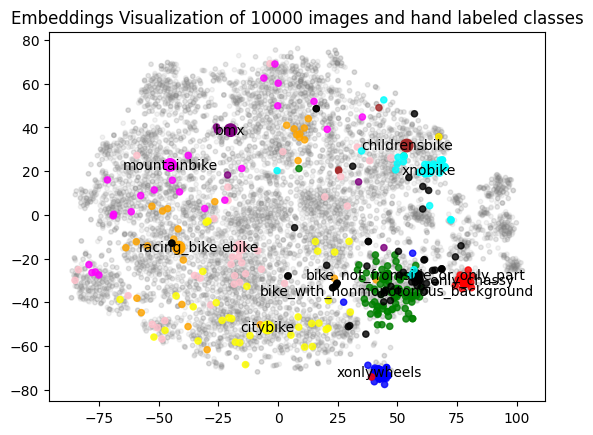

In [32]:
# get some approximate visualization using TSNE
from sklearn.manifold import TSNE



def plot_tsne(embeddings, classification_head:Model=None, title='Embeddings Visualization of 10000 images and hand labeled classes', highlight_image_paths=[]):
  tsne = TSNE(n_components=2)

  embeddings_subset_keys = np.random.choice(list(embeddings.keys()), 10000) # use only subset of embeddings to reduce compute time
  embeddings_subset = [embeddings[p]['embedding'] for p in embeddings_subset_keys]


  labels = [''] * len(embeddings_subset)
  colors = ['grey'] * len(embeddings_subset)
  sizes = [10] * len(embeddings_subset)
  alphas = [0.1] * len(embeddings_subset)

  if len(highlight_image_paths):
    for i, v in enumerate(embeddings_subset_keys):
      if v in highlight_image_paths:
        colors[i] = 'yellowgreen'

  matplotlib_colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple', 'Brown', 'Pink', 'Black', 'Yellow', 'Cyan', 'Magenta', 'Teal']

  class_embeddings = np.array([])
  for i,(cls_name, cls) in enumerate(image_classes.items()):
    mean_embedding = [cls['mean_embedding']]
    embd = cls['embeddings']

    if len(class_embeddings) ==0:
      class_embeddings = np.concatenate([mean_embedding,embd])
    else:
      class_embeddings = np.concatenate([class_embeddings,mean_embedding,embd])

    labels += [cls_name] +['']*len(embd)
    colors += [matplotlib_colors[i]] * (1+len(embd))
    sizes += [80]+ [20] * (len(embd))
    alphas += [1]+ [0.8] * (len(embd))



  embeddings_subset = np.concatenate([embeddings_subset, class_embeddings])

  embeddings_subset_predictions = None
  if classification_head is not None:
    embeddings_subset_predictions = classification_head.predict(embeddings_subset)
    embeddings_subset = embeddings_subset_predictions

  embeddings_subset = tsne.fit_transform(embeddings_subset)
  plt.title(title)
  plt.scatter(embeddings_subset[:, 0], embeddings_subset[:, 1], c=colors, s=sizes,alpha=alphas);
  for i, label in enumerate(labels):
      plt.text(embeddings_subset[i, 0], embeddings_subset[i, 1], label, ha='center', va='center');
  return embeddings_subset_predictions, embeddings_subset, embeddings_subset_keys


plot_tsne(embeddings);

With TSNE a high-dimensional space can be reduced to a lower one. This reduced mapping is only useful for visualization, since distances from the high-dimensional space can not be reproduced exactly. Regardless, the visualization shows that the embeddings obtained with the ResNet may be useful in filtering out unwanted images: Some clusters can be observed, for example around "xonlywheels", "bike_with_nonmonotonous_background" or "x_only_chassy".  It is observed that "childrens bikes" are similar to "xnobike", mostly "xnobike" are childrens bikes without pedals. The large point corresponds to the mean embedding from each class.

The process is repeated, this time the predictions of the pretrained ResNet classification-head are used to represent the images.

324/324 [==============================] - 3s 9ms/step


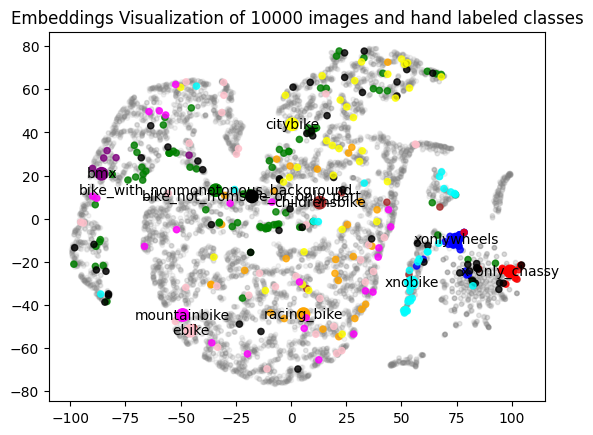

In [33]:
# get some approximate visualization using TSNE, this time with the pretrained classification-head
clf_head_tsne_predictions, clf_head_tsne_2dembeddings,  clf_head_tsne_paths = plot_tsne(embeddings, classification_head=model_clf_head)

This visualization shows the two-dimensional approximation of the ResNets class predictions for the images. These embeddings might be preferable for removing the images from classes "x_only_chassy", "xnobike" and others separated to the right side, since they are separated more clearly here. In contrast, as expected, the predictions largely ignore the background and only focus on the object in the image. Therefore "bike_with_nonmonotonous_background" is not "clustered" as in the first visualization, but spread across the space.



Next, the maximum class prediction of each image is computed and the count per class visualized to obtain a better overview (for the subset of 10000 images)

Top 20 Predicted class counts for the 10000 images, imagenet has no 'bicycle' class:
mountain_bike 8204 images, class index: 671


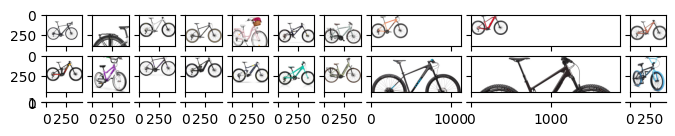

bicycle-built-for-two 625 images, class index: 444


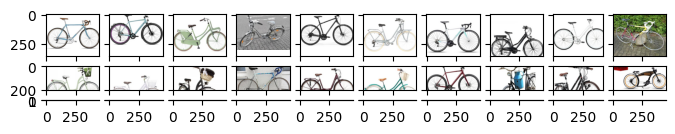

tricycle 360 images, class index: 870


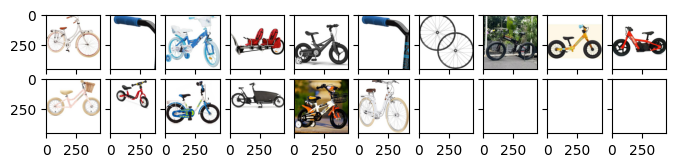

crash_helmet 149 images, class index: 518


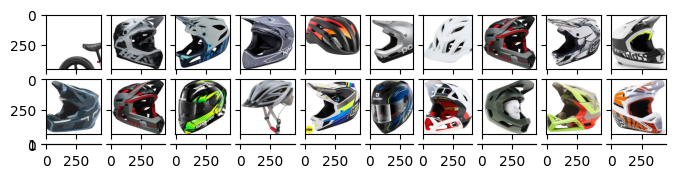

disk_brake 113 images, class index: 535


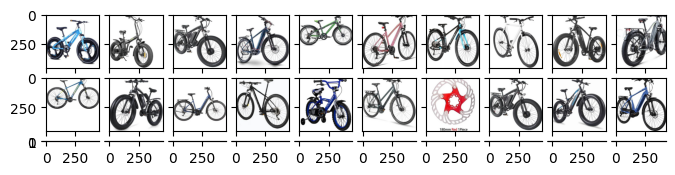

moped 87 images, class index: 665


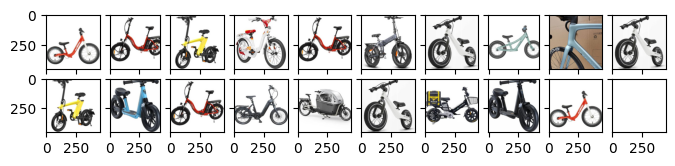

running_shoe 65 images, class index: 770


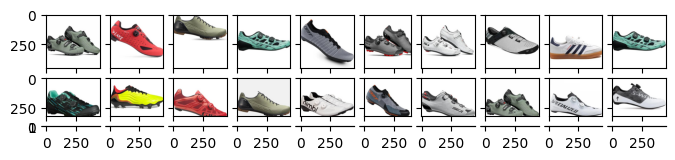

tripod 49 images, class index: 872


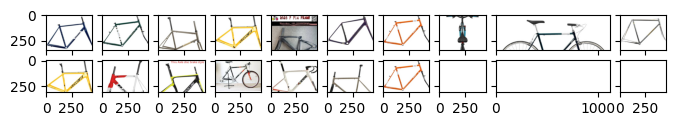

unicycle 48 images, class index: 880


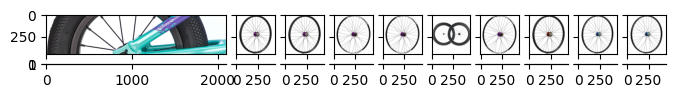

hook 33 images, class index: 600


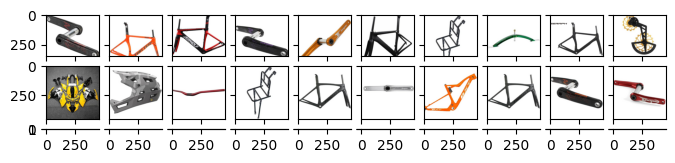

clog 28 images, class index: 502


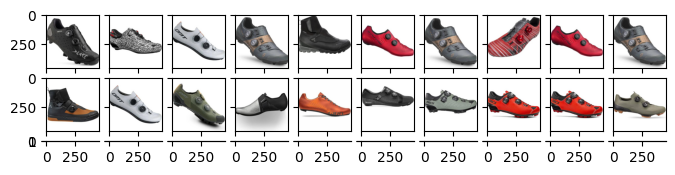

sweatshirt 19 images, class index: 841


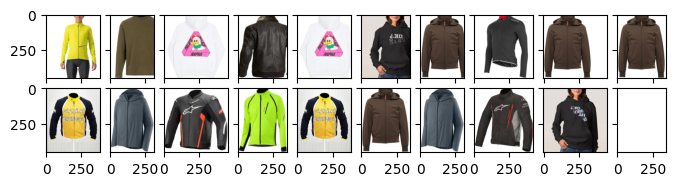

sandal 15 images, class index: 774


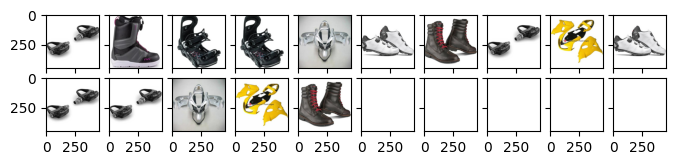

folding_chair 13 images, class index: 559


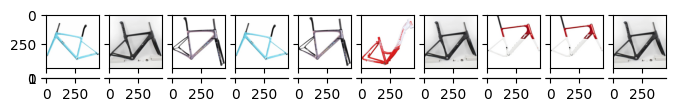

mailbag 13 images, class index: 636


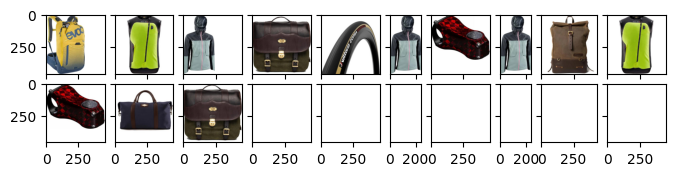

nail 12 images, class index: 677


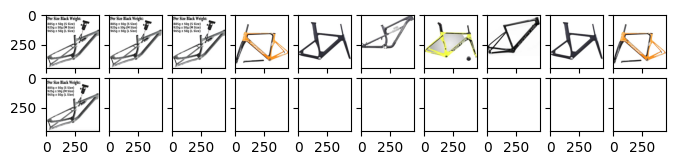

mask 12 images, class index: 643


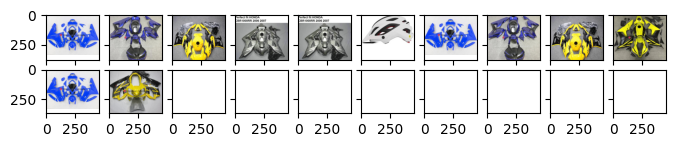

can_opener 11 images, class index: 473


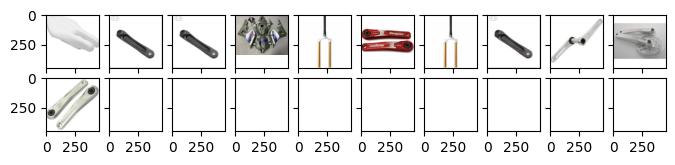

analog_clock 11 images, class index: 409


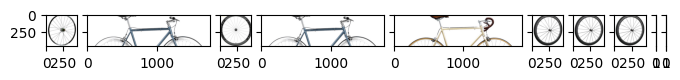

magnetic_compass 11 images, class index: 635


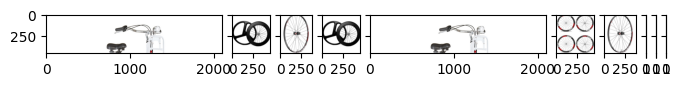

In [35]:
from keras.applications.imagenet_utils import decode_predictions
class_labels = decode_predictions((np.ones(1000)*999-np.arange(1000)).reshape((1,1000)),top=1000)
class_labels = np.array(class_labels)[:,:,1].reshape(-1) # ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', ...]
max_prediction_index = np.argmax(clf_head_tsne_predictions, axis=1)

class_index,counts = np.unique(max_prediction_index, return_counts=True)

sorted_idx = np.argsort(counts)[::-1]
sorted_counts = counts[sorted_idx]
sorted_classes = class_index[sorted_idx]
sorted_class_labels = [class_labels[i] for i in sorted_classes]
print("Top 20 Predicted class counts for the 10000 images, imagenet has no 'bicycle' class:")



# visualize top 5
for i in range(20):
  print(f"{sorted_class_labels[i]} {sorted_counts[i]} images, class index: {sorted_classes[i]}")

  cls = sorted_classes[i]
  index = np.argwhere(max_prediction_index==cls).reshape(-1)
  index = np.random.choice(index,min(20, len(index)))
  index = index[index<10000] # only get original images indices, not labeled or center indices

  plot_image_urls(clf_head_tsne_paths[index])

Observations:
- most images correspond to the "mountainbike" classification, as the imagenet does not include a general "bicycle" class
- all classes, except [mountain_bike, bicycle-built-for-two, tricycle, disk_brake, moped] can be removed savely
- classes like "knee_pad" and "sandal" show that duplicate images can exist, which should be removed in later steps

Next step: remove all images, except [mountain_bike, bicycle-built-for-two, tricycle, disk_brake, moped]

In [36]:
all_embeddings_paths = list(embeddings.keys())
all_embeddings_vectors = np.array([embeddings[p]['embedding'] for p in all_embeddings_paths])
all_embeddings_vectors.shape

(59233, 2048)

In [37]:
all_embeddings_vectors_predicted = model_clf_head.predict(all_embeddings_vectors)

1852/1852 [==============================] - 15s 8ms/step


In [38]:
all_embeddings_vectors_predicted.shape

(59233, 1000)

In [39]:
# remove all images except those with highest prediction in classes of the keep list
keep = ["mountain_bike", "bicycle-built-for-two", "tricycle", "disk_brake", "moped"]
keep_idx = []
for cls in keep:
  keep_idx.append(np.argwhere(class_labels==cls)[0][0])

max_class_predicted = np.argmax(all_embeddings_vectors_predicted,axis=1)
keep_indices = []
for i, cls in enumerate(max_class_predicted):
  if cls in keep_idx:
    keep_indices.append(i)

keep_embeddings_paths = np.array(all_embeddings_paths)[keep_indices]


In [40]:
clf_head_tsne_paths.shape

(10000,)

In [41]:
keep_embeddings_paths.shape

(54008,)

In [42]:
len(set(keep_embeddings_paths)-set(clf_head_tsne_paths))

45634

In [43]:
print(f"keep {len(keep_embeddings_paths)} images, removed { len(all_embeddings_paths) - len(keep_embeddings_paths)} images")

keep 54008 images, removed 5225 images


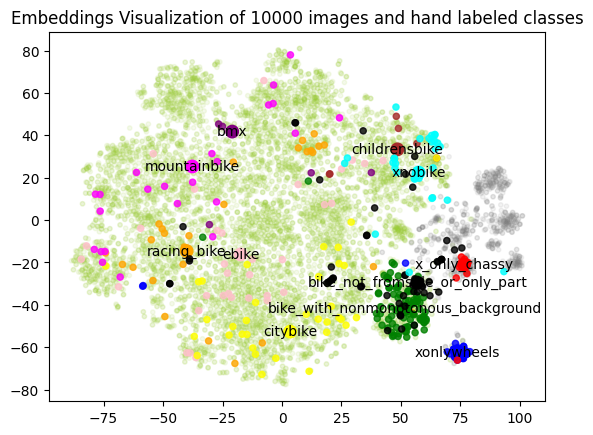

In [96]:
plot_tsne(embeddings,highlight_image_paths=list(keep_embeddings_paths));

324/324 [==============================] - 3s 8ms/step


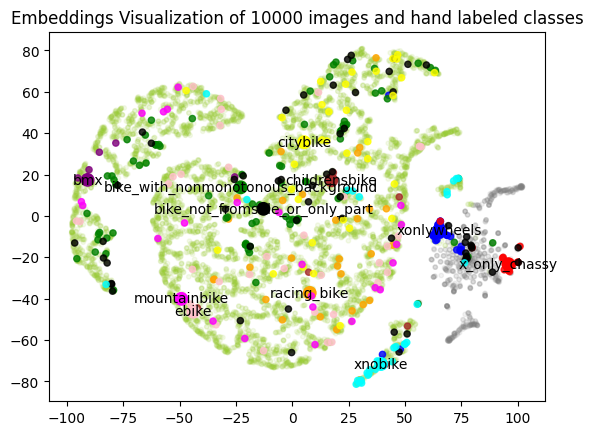

In [97]:
plot_tsne(embeddings, classification_head=model_clf_head,highlight_image_paths=list(keep_embeddings_paths));

Visual confirmation of removal: the images highlighted grey in the plots are removed, the green ones are kept. Below is a visual confirmation of what was removed

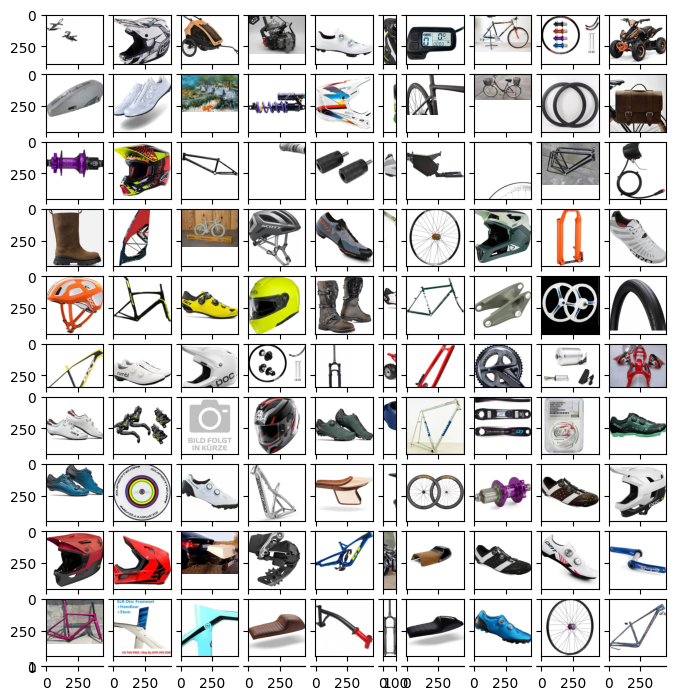

In [46]:
remove_embeddings_paths = list(set(all_embeddings_paths)- set(keep_embeddings_paths))
plot_image_urls(np.random.choice(remove_embeddings_paths,100))

The removal is successful, as out of 100 images, not one is an actual bike. In total 5225 images are removed

For the remaining "xnobike", 1000-dimensional prediction embeddings are used. Because in the TSNE- Visualization for these embeddings show greater separation for the class in comparision to the average-pooling embeddings.

To differentiate between the other embeddings and those of the class, LDA is used.

In [277]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


keep_embeddings = [embeddings[path]['embedding'] for path in keep_embeddings_paths]
keep_embeddings_labels = ["Other"]*len(keep_embeddings)

keep_embeddings_remove_xnobike = keep_embeddings_labels
for path in image_classes['xnobike']['images']:
  name = Path(path).name
  if name in keep_embeddings_paths:
    keep_embeddings_remove_xnobike[np.where(keep_embeddings_paths==name)[0][0]] = 'xnobike'



keep_embeddings_1000 = model_clf_head.predict(np.array(keep_embeddings))
lda = LinearDiscriminantAnalysis(n_components=1)
keep_embeddings_lda = lda.fit_transform(keep_embeddings_1000, keep_embeddings_labels)

1688/1688 [==============================] - 13s 7ms/step


In [278]:
keep_embeddings_lda = keep_embeddings_lda.reshape(-1)

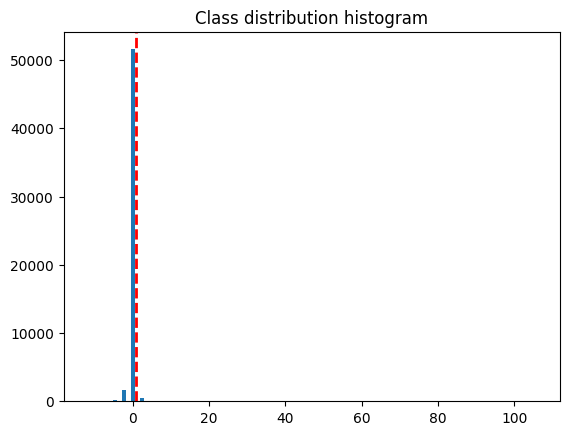

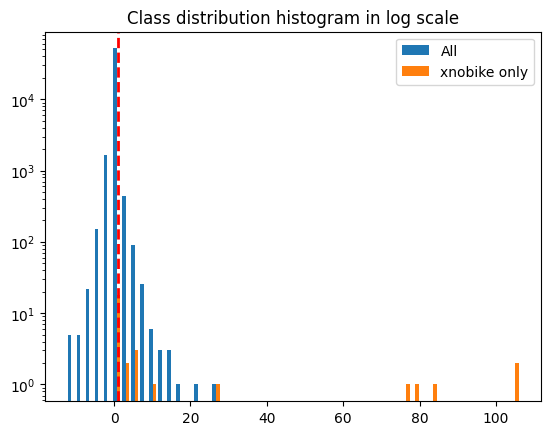

In [361]:
group_keep = []
group_remove = []
for i in range(len(keep_embeddings_labels)):
  if keep_embeddings_labels[i] =='Other':
    group_keep.append(keep_embeddings_lda[i])
  else:
    group_remove.append(keep_embeddings_lda[i])

plt.title('Class distribution histogram')
plt.hist([group_keep,group_remove], bins=50, label=['All','xnobike only'])
plt.axvline(x=1, color='red', linestyle='--', linewidth=2)
plt.show()
plt.title('Class distribution histogram in log scale')
plt.hist([group_keep,group_remove], bins=50, label=['All','xnobike only'])
plt.yscale('log')
plt.axvline(x=1, color='red', linestyle='--', linewidth=2)
plt.legend();

No absolute numbers of the count of xnobike images is available, because only a limited amount of images is hand-labeled. Therefore methods which use the class prior to determine the decision boundary can not be used. For simplification, a manual boundary of 1 is chosen (red line). This is based on the following examination of the images of the blue and orange distributions in proximity to the right of this line.

-------------- Nearest Images for a boundary of 4 --------------
155 images to the right
Others


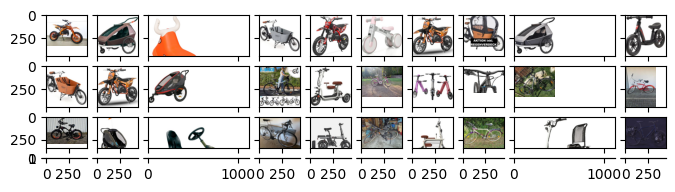

xnobike


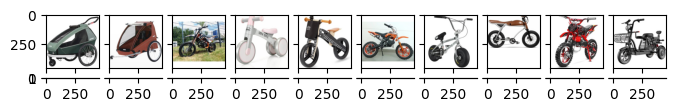




-------------- Nearest Images for a boundary of 3 --------------
255 images to the right
Others


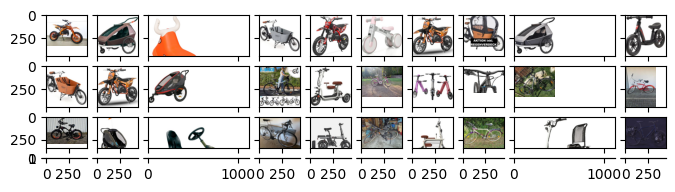

xnobike


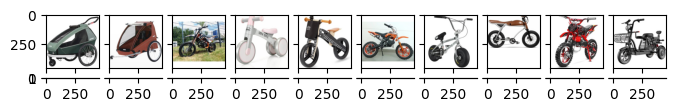




-------------- Nearest Images for a boundary of 2 --------------
491 images to the right
Others


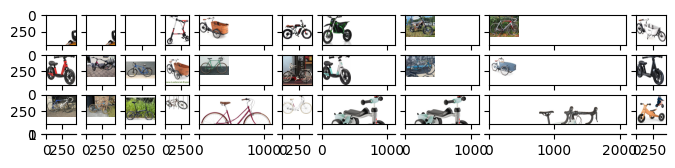

xnobike


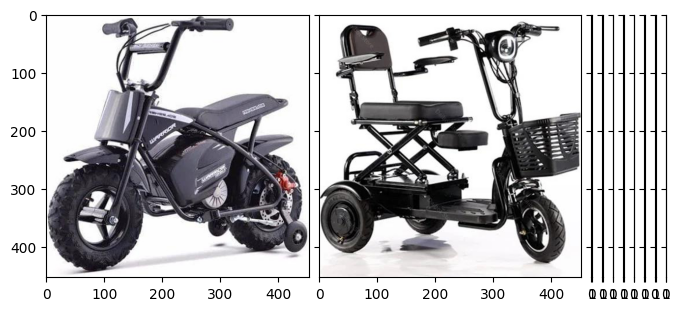




-------------- Nearest Images for a boundary of 1.5 --------------
761 images to the right
Others


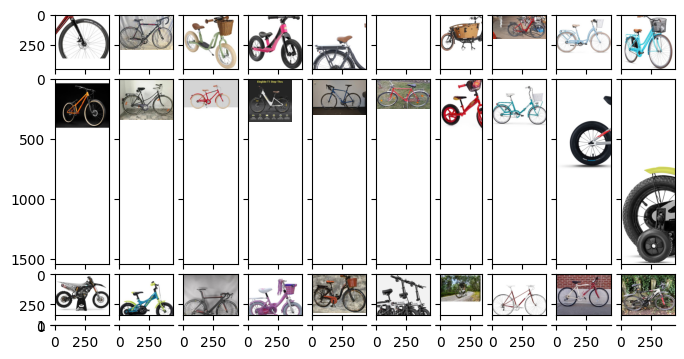

xnobike


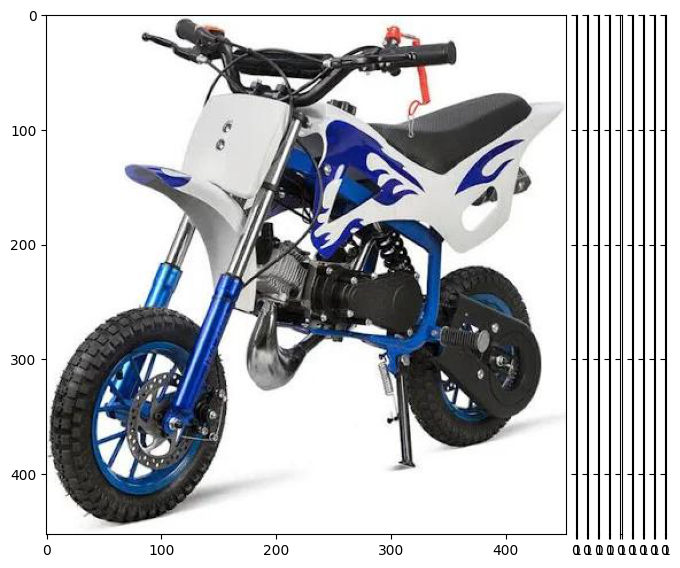




-------------- Nearest Images for a boundary of 1 --------------
1987 images to the right
Others


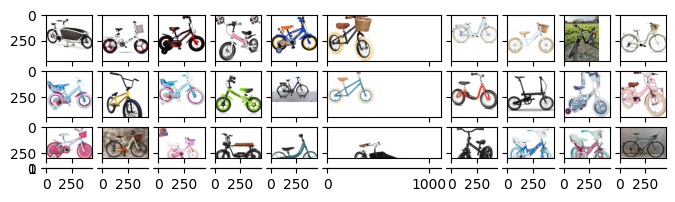

xnobike
no labeled xnobike images in proximity



-------------- Nearest Images for a boundary of 0.5 --------------
3444 images to the right
Others


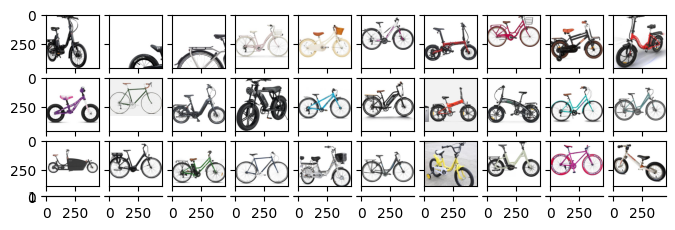

xnobike


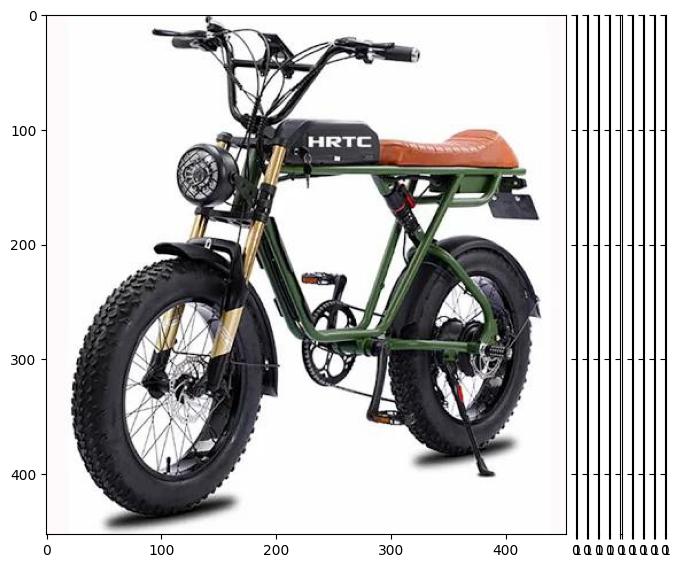




-------------- Nearest Images for a boundary of 0 --------------
13169 images to the right
Others


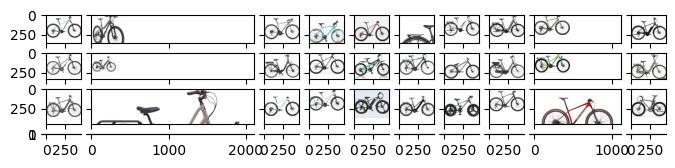

xnobike
no labeled xnobike images in proximity





In [283]:

for bound in [4,3,2,1.5,1,0.5,0]:
  diff = bound-keep_embeddings_lda
  to_the_right_index = np.argwhere(diff<=0)[:,0]
  diff = diff[to_the_right_index]

  nearest_100 = np.argsort(diff)[-300:]
  nearest_100_diffs = diff[nearest_100]

  nearest_100_paths = keep_embeddings_paths[to_the_right_index[nearest_100]]
  nearest_100_classes = ['Other'] * len(nearest_100_paths)
  for i,path in enumerate(image_classes['xnobike']['images']):
    name = Path(path).name
    if name in nearest_100_paths:
      nearest_100_classes[np.where(nearest_100_paths==name)[0][0]] = 'xnobike'


  others = [tup for tup in zip(nearest_100_diffs, nearest_100_paths, nearest_100_classes  ) if tup[2] !='xnobike']
  xnobike = [tup for tup in zip(nearest_100_diffs, nearest_100_paths, nearest_100_classes  ) if tup[2] =='xnobike']


  print(f'-------------- Nearest Images for a boundary of {bound} --------------')
  print(f'{to_the_right_index.shape[0]} images to the right')
  print(f'Others')
  plot_image_urls(np.array(others)[:30,1])

  print('xnobike')

  if len(xnobike):
    plot_image_urls(np.array(xnobike)[:30,1])
  else:
    print('no labeled xnobike images in proximity')

  print('\n\n')

It can be observed that with smaller boundaries, the images become less bulky and also less childrens bikes are contained.
a conservative boundary of 1 is chosen, which removes 1987 images from the dataset.

In [285]:
diff = 1-keep_embeddings_lda
keep_index = np.argwhere(diff>0)[:,0]

keep_embeddings_paths_without_xnobike = keep_embeddings_paths[keep_index]

print(f"Remove {len(keep_embeddings_paths)-len(keep_index)} images, keep {len(keep_embeddings_paths_without_xnobike)} images")

Remove 1987 images, keep 52021 images


To remove bikes with background which is not white, simple pixel metrics can be utilized. Following code converts an image to grayscale and returns the normalized pixel darkness

In [303]:
from PIL import Image

def get_darkness(image_name):
  if image_name not in imagename_to_path.keys():
    print('Image does not exist')
    return
  image_name = imagename_to_path[image_name]
  image = Image.open(image_name)
  image = image.convert("L") # convert to grayscale
  image = np.array(image)
  score = np.sum(image)
  normalized_pixel_score = score/(image.shape[0]*image.shape[1])
  return normalized_pixel_score/255


In [304]:
keep_embeddings_darkness_scores = []
for path in tqdm(keep_embeddings_paths_without_xnobike):
  keep_embeddings_darkness_scores.append(get_darkness(path))

  0%|          | 0/52021 [00:00<?, ?it/s]

Image does not exist
Image does not exist


Two images do not exist in the original set of images (From the hand labeled images). These are removed

In [331]:
keep_embeddings_paths_without_xnobike_clean = []
darkness_scores = []
for i in range(len(keep_embeddings_paths_without_xnobike)):
  if keep_embeddings_darkness_scores[i] is None:
    continue

  darkness_scores.append(keep_embeddings_darkness_scores[i])
  keep_embeddings_paths_without_xnobike_clean.append(keep_embeddings_paths_without_xnobike[i])



Compare the mean of darkness scores of images with non-monotonous background to that of all images:

In [343]:
labels = ['Others']* len(darkness_scores)
for path in image_classes['bike_with_nonmonotonous_background']['images']:
  name = Path(path).name
  if name in keep_embeddings_paths_without_xnobike_clean:
    labels[keep_embeddings_paths_without_xnobike_clean.index(name)] ='bike_with_nonmonotonous_background'

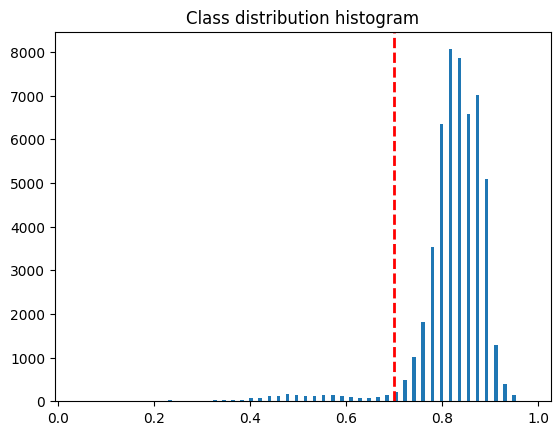

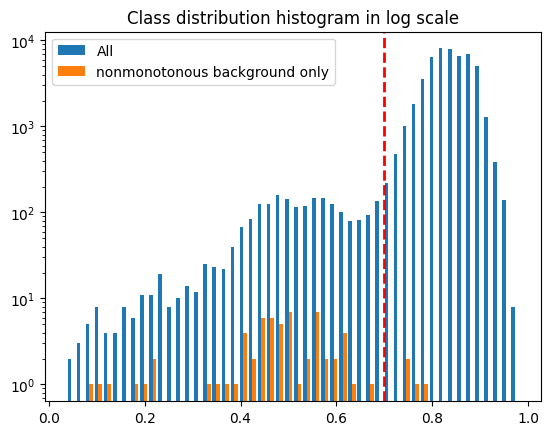

In [360]:
group_keep = []
group_remove = []
for i in range(len(labels)):
  if labels[i] =='Others':
    group_keep.append(darkness_scores[i])
  else:
    group_remove.append(darkness_scores[i])

plt.title('Class distribution histogram')
plt.hist([group_keep,group_remove], bins=50, label=['All','nonmonotonous background only'])
plt.axvline(x=0.7, color='red', linestyle='--', linewidth=2)
plt.show()
plt.title('Class distribution histogram in log scale')
plt.hist([group_keep,group_remove], bins=50, label=['All','nonmonotonous background only'])
plt.yscale('log')
plt.axvline(x=0.7, color='red', linestyle='--', linewidth=2)
plt.legend();

0.7 is chosen as boundary based on the images below

-------------- Nearest Images for a boundary of 0.5 --------------
903 images to the left
Others


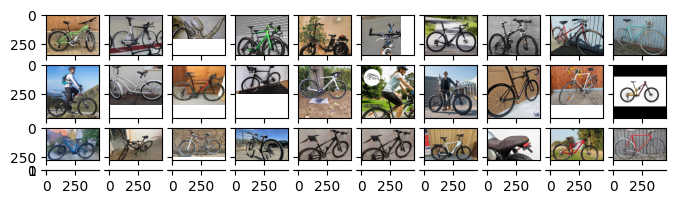

labeled non-monotonous images


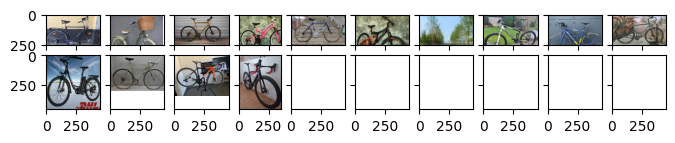




-------------- Nearest Images for a boundary of 0.6 --------------
1634 images to the left
Others


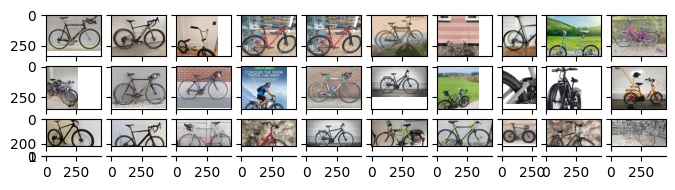

labeled non-monotonous images


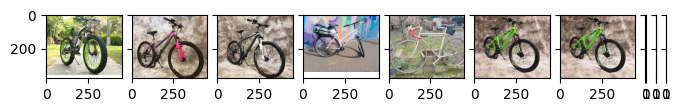




-------------- Nearest Images for a boundary of 0.65 --------------
1867 images to the left
Others


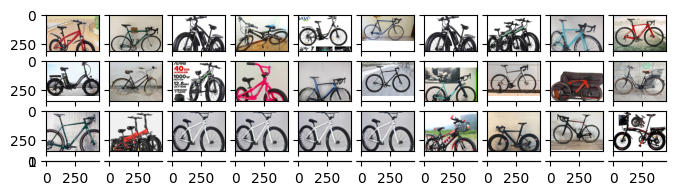

labeled non-monotonous images


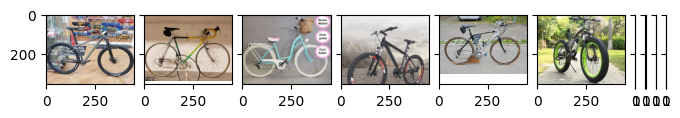




-------------- Nearest Images for a boundary of 0.7 --------------
2164 images to the left
Others


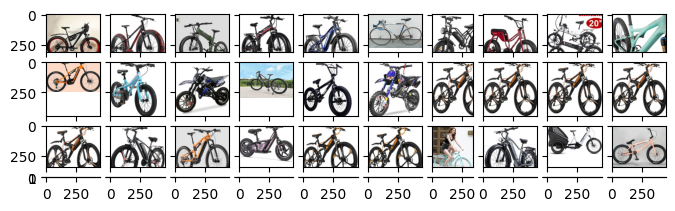

labeled non-monotonous images


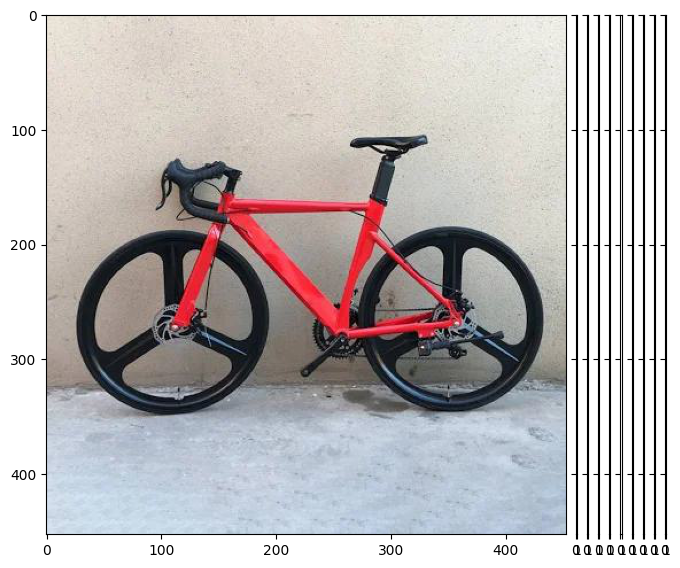




-------------- Nearest Images for a boundary of 0.75 --------------
3527 images to the left
Others


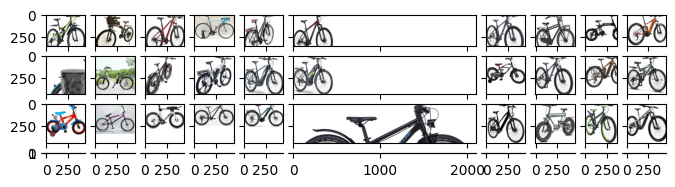

labeled non-monotonous images


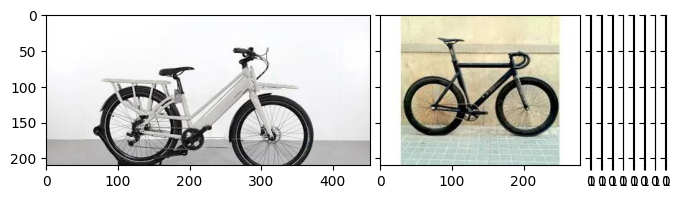




-------------- Nearest Images for a boundary of 0.8 --------------
11348 images to the left
Others


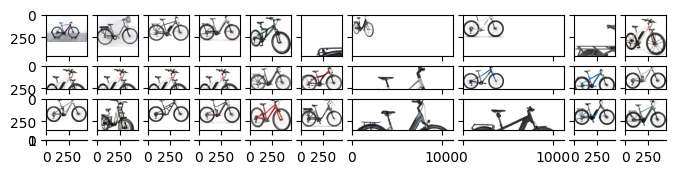

labeled non-monotonous images
no labeled non-monotonous images in proximity





In [358]:
for bound in [0.5,0.6,0.65,0.7,.75,.8]:#,0.7,.75,0.8]:
  diff = bound-np.array(darkness_scores)
  to_the_left_index = np.argwhere(diff>=0)[:,0]
  diff = diff[to_the_left_index]

  nearest_100 = np.argsort(diff)[:300]
  nearest_100_diffs = diff[nearest_100]

  nearest_100_paths = np.array(keep_embeddings_paths_without_xnobike_clean)[to_the_left_index[nearest_100]]
  nearest_100_classes = ['Others'] * len(nearest_100_paths)
  for i,path in enumerate(image_classes['bike_with_nonmonotonous_background']['images']):
    name = Path(path).name
    if name in nearest_100_paths:
      nearest_100_classes[np.where(nearest_100_paths==name)[0][0]] = 'bike_with_nonmonotonous_background'


  others = [tup for tup in zip(nearest_100_diffs, nearest_100_paths, nearest_100_classes  ) if tup[2] !='bike_with_nonmonotonous_background']
  xnobike = [tup for tup in zip(nearest_100_diffs, nearest_100_paths, nearest_100_classes  ) if tup[2] =='bike_with_nonmonotonous_background']


  print(f'-------------- Nearest Images for a boundary of {bound} --------------')
  print(f'{to_the_left_index.shape[0]} images to the left')
  print(f'Others')
  plot_image_urls(np.array(others)[:30,1])

  print('labeled non-monotonous images')

  if len(xnobike):
    plot_image_urls(np.array(xnobike)[:30,1])
  else:
    print('no labeled non-monotonous images in proximity')

  print('\n\n')

In [363]:
diff = 0.7-np.array(darkness_scores)
keep_index = np.argwhere(diff<0)[:,0]

keep_embeddings_paths_without_xnobike_without_nonmonotonous = np.array(keep_embeddings_paths_without_xnobike_clean)[keep_index]
print(f"Remove {len(keep_embeddings_paths_without_xnobike_clean)-len(keep_index)} images, keep {len(keep_embeddings_paths_without_xnobike_without_nonmonotonous)} images")

Remove 2164 images, keep 49855 images


The following is a visual confirmation of the removal of xnobike and non-monotonous images

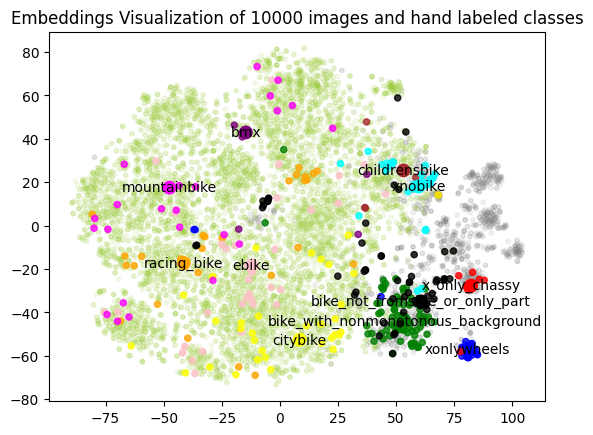

In [368]:
plot_tsne(embeddings,highlight_image_paths=list(keep_embeddings_paths_without_xnobike_without_nonmonotonous));

324/324 [==============================] - 2s 7ms/step


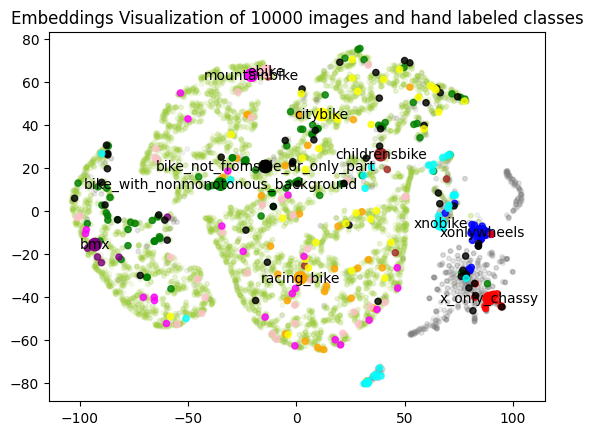

In [369]:
plot_tsne(embeddings, classification_head=model_clf_head,highlight_image_paths=list(keep_embeddings_paths_without_xnobike_without_nonmonotonous));

The plots show that a large part of the non-monotonous(dark green) and xnobike (cyan) images are removed. The annotated images overlay their grey removal-counterparts in some cases

Finally, duplicate images are removed. The l2-distance between the embeddings is an efficient way to solve this problem

Because of memory limitations, the 1000-dimensional embeddings are used instead of the 2024-dimensional

In [1]:
with open('/content/keep_embeddings_paths_without_xnobike_clean.txt', encoding='unicode_escape') as f:
    keep_embeddings_paths_without_xnobike_without_nonmonotonous = f.read().replace("['","").replace("']","").split("', '")

In [2]:
from sklearn.metrics.pairwise import euclidean_distances
duplicate_embeddings = []
for path in keep_embeddings_paths_without_xnobike_without_nonmonotonous:
  duplicate_embeddings.append(embeddings[path]['embedding'])
duplicate_embeddings_predicted = model_clf_head.predict(np.array(duplicate_embeddings))
duplicate_embeddings_predicted = duplicate_embeddings_predicted[:,:10]
#distances = euclidean_distances(duplicate_embeddings_predicted) # calculates pairwise distance between all rows of a matrix.
# for a m x n matrix, resulting distances matrix is m x m
#distances.shape

NameError: ignored

In [377]:
embeddings['germany_6fc42e7c-b6c2-495e-84da-6188ad9bcaae0_129.99.jpg']['embedding']

array([0.20714532, 0.34556133, 0.04806196, ..., 0.1758676 , 0.        ,
       0.3087885 ], dtype=float32)

In [372]:
embeddings['germany_6fc42e7c-b6c2-495e-84da-6188ad9bcaae0_129.99.jpg']['embedding']

array([0.20714532, 0.34556133, 0.04806196, ..., 0.1758676 , 0.        ,
       0.3087885 ], dtype=float32)

In [379]:
embeddings[keep_embeddings_paths_without_xnobike_without_nonmonotonous[0]]['embedding']

array([0.20714532, 0.34556133, 0.04806196, ..., 0.1758676 , 0.        ,
       0.3087885 ], dtype=float32)

Description of procedure:
- apply principle component analysis to the 2024- dimensional embeddings to reduce the dimensionality to a low degree.
- color the classes to see class distribution in this low dimensional space
- apply a gaussian kernel

The idea behind principle component analysis in this setting is to extract the principle components with highest degree of variance. In the ideal case,  these principle components contain the information most useful for the task fo separation.

In [65]:
keep_embeddings = [embeddings[path]['embedding'] for path in keep_embeddings_paths]

In [55]:
from sklearn.decomposition import PCA

In [99]:
np.array(keep_embeddings).shape

(54008, 2048)

In [72]:
pca = PCA(n_components=1)
keep_fitted = pca.fit_transform(keep_embeddings)

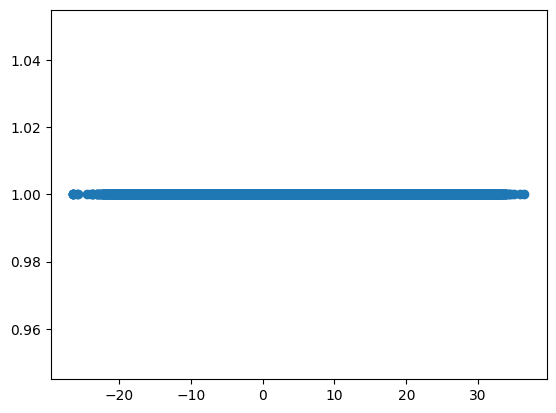

In [75]:
plt.scatter(keep_fitted[:,0],np.ones(len(keep_fitted[:,0])))

In [ ]:
plt.hist()

array([ 3.03704428, -8.91885294, -5.87283537, ...,  2.41323656,
        8.29198429,  0.28644501])

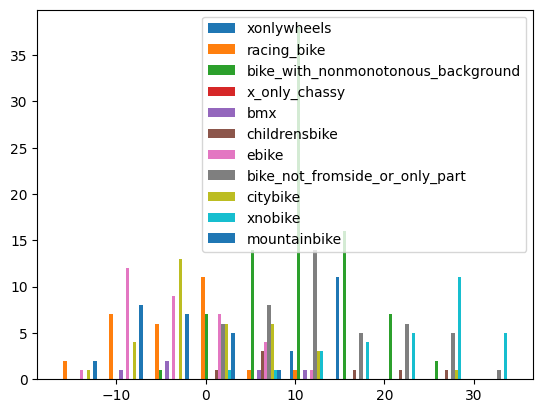

In [95]:

keep_images = keep_fitted.reshape(-1)

labels = []
databins = []
class_indices =[]
for cls, data in image_classes.items():
  plot_images = []
  for path in data['images']:
    image_name = Path(path).name
    if image_name in keep_embeddings_paths:
      index = np.where(keep_embeddings_paths == image_name)[0][0]

      class_indices.append(index)
      plot_images.append(keep_images[index])
  databins.append(plot_images)
  labels.append(cls)

plt.hist(databins, bins=10, label=labels)
plt.legend();


In [64]:
['a','b'].index('a')

0

In [61]:
image_classes

{'xonlywheels': {'remove': True,
  'images': [PosixPath('/content/content/image_classes/xonlywheels/03ee07fa-61f8-3469-a182-1d539e8ba165_291.39.jpg'),
   PosixPath('/content/content/image_classes/xonlywheels/6fe80464-dc90-3589-a002-763654ecb7ec_291.19.jpg'),
   PosixPath('/content/content/image_classes/xonlywheels/5e352093-4f61-3d31-81a5-0153b038ec1e_328.92.jpg'),
   PosixPath('/content/content/image_classes/xonlywheels/3ae44f6b-9d76-3d9a-97cc-0ae1fb0d8798_250.00.jpg'),
   PosixPath('/content/content/image_classes/xonlywheels/9b89e80a-3ad2-3c46-8486-6c42dca8f7e3_301.76.jpg'),
   PosixPath('/content/content/image_classes/xonlywheels/9b05b6d3-7e98-3859-94ea-ccac4aeb4d7a_291.39.jpg'),
   PosixPath('/content/content/image_classes/xonlywheels/9a676d56-6cf1-36c7-94ef-087b58c4b694_388.99.jpg'),
   PosixPath('/content/content/image_classes/xonlywheels/2f30dd81-e5a9-3527-908b-638886297999_350.00.jpg'),
   PosixPath('/content/content/image_classes/xonlywheels/1c083c89-a323-328b-88f2-1a7030a2f7ae

In [57]:
keep_fitted.shape

(54008, 2)

Next, the clusters at ~(60,-60) and ~(100,10) are identified

In [ ]:
embeddings_subset_keys.shape

In [ ]:
cluster1 = np.array([[60,-60]])
cluster2 = np.array([[100,10]])
# compute cosine similarity
cosine1 = cosine_similarity(embeddings_2d_clfhead, cluster1)
cosine2 = cosine_similarity(embeddings_2d_clfhead, cluster2)

# get indices of 10 nearest images
idx1 = np.argpartition(cosine1,-20, axis=0)[-20:]
idx2 = np.argpartition(cosine2,-20, axis=0)[-20:]

# plot nearest images
print('Cluster (60,-60) ')
plt.scatter(embeddings_2d_clfhead[:, 0], embeddings_2d_clfhead[:, 1], c='grey')
plt.scatter(*cluster1.reshape(-1))
plot_image_urls(embeddings_subset_keys[idx1[idx1<10000]])
print('Cluster (100,10) ')
plt.scatter(embeddings_2d_clfhead[:, 0], embeddings_2d_clfhead[:, 1], c='grey')
plt.scatter(*cluster2.reshape(-1))



plot_image_urls(embeddings_subset_keys[idx2[idx2<10000]])

In [ ]:
embeddings_subset_keys[idx1].reshape(-1)

In [ ]:
class_embeddings

In [ ]:
type(embeddings_lookup._dict['3c206aa6-4f90-3714-b714-3e68b9a5741b_392.99.jpg'])

## 3. Hyperparameter selection (And reasons for selection): Loss Function, Image Size, Model, Finetuning approach (transfer learning)

## 4. Hyperparameter selection: Optimizer, Learning Rate, Batch Size, Regression Layer depth, (Epochs)

- use bayesian optimization, see https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

## 5. Layer Activation Visualization

==One Problem was that visualization did not work, because I used a keras model as base model, and my own regression head on top, therefore could not access the base model layers==

maybe some kind of embedding visualization with TSNE / UMAP, e.g. show that classes are close to each other (plot the actual images in 2d plot) -> pretrained model without regression head could be used for classification

## 6. Conclusion